<h4>Lily Grumbach
    <br>M1 Humanités numériques - Université PSL</h4>
<h1><center>Rendu TAIS-TAL </center></h1>
<h2><center>Partie TAIS</center></h2>
<h3><center>2/3 : Extraire des bases de données à ma disposition les coordonnées des lieux et créer un dictionnaire de désambiguisation de mes données</center></h3>

<b><u>PLAN:</u></b>
1) Harmonisation des données Géopolitiques pour le fond de carte de 1914
<br>
    
<h4>2) Reconstruire et adapter la base de l'IREL aux données à disposition</h4>
<br/>
    
3) Géoréférencer les données de mes revues

<b>Stratégie en place :  </b>

Nous avons 3 sources possibles de désambiguisation : 
* **Wikidata** indiqués par le medialab 
* l'**IREL**, la base de données géographique de l'inventaire en ligne des Archives nationales d'Outre Mer
* **Geonames**, pour le meilleur et pour le pire.

<h3>Objectifs de la partie : </h3>
1) A court terme : récupérer les coordonnées géographiques des lieux mentionnés dans notre revue


2) A long terme : avoir à disposition une base de données géographique historique exploitable pour des projets futurs.

# Import des modules

In [1]:
#module
import desambiguisation
##General : 
from desambiguisation import ListEntities2df
##GPH
from desambiguisation import MatchGPELOC_IREL,Extract_longlat_WikiData

##IREL : 
from desambiguisation import nettoyage_df_IREL,urlencode,Extract_longlat_IREL,IREL_Nettoyage_AdminLieuDit

#Généraux
import pandas as pd
import re
import numpy as np

#Webscrapping
from bs4 import BeautifulSoup
import geocoder
from lxml import html
import requests

#Wikidata 
import qwikidata

# 0. Les df de référence

**AHMC**

In [2]:
##AHMC
df_AHMC_annote = pd.read_csv('./df_annotes/dfAHMCannotations.csv')

#Ne conserver qu'une partie du df
df_AHMC_annote = df_AHMC_annote[["article_titre","revue_annee","GPE_ents","LOC_ents","ORG_ents"]]

#Extraire les entités GPE,LOC,ORG
liste_GPEAHMC = ListEntities2df(df_AHMC_annote,"AHMC","GPE_ents")
liste_LOCAHMC = ListEntities2df(df_AHMC_annote,"AHMC","LOC_ents")
liste_ORGAHMC = ListEntities2df(df_AHMC_annote,"AHMC","ORG_ents")

fichier créé dans ./desambiguisation/Revue_ParEntityLabel/AHMC/AHMCGPE_ents.csv
Output:liste des entités GPE_ents 

fichier créé dans ./desambiguisation/Revue_ParEntityLabel/AHMC/AHMCLOC_ents.csv
Output:liste des entités LOC_ents 

fichier créé dans ./desambiguisation/Revue_ParEntityLabel/AHMC/AHMCORG_ents.csv
Output:liste des entités ORG_ents 



**AMN**

In [3]:
#AMN
df_AMN_annote = pd.read_csv('./df_annotes/dfAMNannotations.csv')

#Ne conserver qu'une partie du df
df_AMN_annote = df_AMN_annote[["article_titre","revue_annee","GPE_ents","LOC_ents","ORG_ents"]]

#Extraire les entités GPE,LOC,ORG
liste_GPEAMN = ListEntities2df(df_AMN_annote,"AMN","GPE_ents")
liste_LOCAMN = ListEntities2df(df_AMN_annote,"AMN","LOC_ents")
liste_ORGAMN = ListEntities2df(df_AMN_annote,"AMN","ORG_ents")

fichier créé dans ./desambiguisation/Revue_ParEntityLabel/AMN/AMNGPE_ents.csv
Output:liste des entités GPE_ents 

fichier créé dans ./desambiguisation/Revue_ParEntityLabel/AMN/AMNLOC_ents.csv
Output:liste des entités LOC_ents 

fichier créé dans ./desambiguisation/Revue_ParEntityLabel/AMN/AMNORG_ents.csv
Output:liste des entités ORG_ents 



# 1. Désambiguisation de la liste des GPE et LOC

In [4]:
list_GPELOC = liste_GPEAMN+liste_LOCAMN+liste_LOCAHMC+liste_GPEAHMC
print("Nombre de lieux à annoter : ",len(list_GPELOC))

Nombre de lieux à annoter :  260


Dictionnaire et liste des Faux positifs relevés dans la liste :

In [5]:
#dictionnaire pour la désambiguisation :
Dico_desambiguisation = {"Guinée Française":["Guinée française"],
                         "Côte d'Ivoire":["côte d'Ivoire"],
                         "Pak-Hoi":["Pak-Hoï","Pakhoï"],
                         "Chengdu":['Tchen-Tou','Tchentou'],
                         "Yunnan":['Yun-Nam','Yun-Nan','Yunnam'],
                         "Hanoi":["Hanoï"],
                         "Laokay":["Lao-kay"],
                         "Côte d'Ivoire":["Côte d\'Ivoire","côte d'Ivoire"]
                        }
Liste_FP = ["Annamite","Annamites","île"]

In [6]:
#désambiguiser :
for i in range(len(list_GPELOC)):
    for (key,val) in Dico_desambiguisation.items():
            for name in val:
                if list_GPELOC[i]==name :
                    list_GPELOC[i]=key

#retirer lesfaux positifs :
for FP in Liste_FP:
    print(FP)
    list_GPELOC.remove(FP)
# list_GPELOC

Annamite
Annamites
île


In [7]:
#Retirer les doublons de la liste :
print("avant dédoublonnage : ",len(list_GPELOC))
list_GPELOC = list(dict.fromkeys(list_GPELOC))
print("après dédoublonnage : ",len(list_GPELOC))

avant dédoublonnage :  257
après dédoublonnage :  225


In [8]:
#Mise en df pour exploitation plus tard
df_GPELOC = pd.DataFrame({"entités à annoter":list_GPELOC})

In [9]:
df_GPELOC

,entités à annoter
0,Acores
1,Algérie
2,Allemagne
3,Angleterre
4,Annam
...,...
220,lac Tchad.
221,île de Saint-Barthélémy
222,île de Saint-Martin
223,île de la Réunion


# 2. Reconstituer les bases les coordonnées des BDD à ma disposition

## 2.1. Importation et première exploration des BDD
NB : je n'applique cela qu'aux BDD GPH et IREL car Geonames est beaucoup trop volumineux.

### 2.1.1. GPH 

In [10]:
#import du df GPH entities avec lien wikidata
with open ("./GeoPolHist-202103/medialab-GeoPolHist-fb19b66/data/GeoPolHist_entities.csv") as f :
    df_wikiData = pd.read_csv(f)
df_wikiData.rename(columns={"GPH_name":"NAME"})

,GPH_code,NAME,continent,wikidata,wikidata_alt1,wikidata_alt2,wikidata_alt3,notes
0,2,United States of America,America,http://www.wikidata.org/entity/Q30,NaN,NaN,NaN,NaN
1,3,Alaska,America,http://www.wikidata.org/entity/Q797,NaN,NaN,NaN,NaN
2,4,Hawaii,America,http://www.wikidata.org/entity/Q782,NaN,NaN,NaN,NaN
3,5,Virgin Islands,America,http://www.wikidata.org/entity/Q11703,NaN,NaN,NaN,NaN
4,6,Puerto Rico,America,http://www.wikidata.org/entity/Q1183,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1223,9994,Ross Dependency,Oceania,http://www.wikidata.org/entity/Q203073,NaN,NaN,NaN,NaN
1224,9998,Concessions in China,World,https://www.wikidata.org/wiki/Q1376651,NaN,NaN,NaN,NaN
1225,9999,Inter-Allied Commission of Control,World,https://www.wikidata.org/wiki/Q1665892,NaN,NaN,NaN,NaN
1226,0,League of Nations,World,https://www.wikidata.org/wiki/Q38130,NaN,NaN,NaN,NaN


Pour ne conserver que les données qui nous intéressent, on le merge avec la base de données finale de la Partie 1

In [11]:
#Importer le df de référence (jusqu'à 1914)
df_MANUEL = pd.read_csv("./output_finaux/df_1914manuelCarto.csv")

#Merge avec les données complétées manuellement 
df_WikiQGIS=pd.merge(df_wikiData,df_MANUEL,how="right",on="GPH_code")

#Export : 
df_WikiQGIS.to_csv("./WikiQGIS.csv")

###  2.1.2. IREL

Nettoyer la base de donnée IREL (cf module)

In [12]:
dico_IREL ={}
n=0

with open('./IREL/liste_lieux_IREL.js','r') as f:
    lignes = f.readlines()
    
    for l in lignes:
        l=l.split("\n")
        dico_IREL[n]=l
        n+=1

df_IREL = nettoyage_df_IREL(dico_IREL)

return: df_IREL nettoyé


### 2.1.3. Merge df_IREL et df_WikiData pour avoir les lieux présents dans les deux bases de données

In [13]:
df_IREL=df_IREL.rename(columns={"Lieu-dit":"NAME"})
df_wikiData=df_wikiData.rename(columns={"GPH_name":"NAME"})

df_WikiIREL = pd.merge(df_wikiData,df_IREL,how="inner",on="NAME")

#Attention : je drop les duplicatas sur les GPH_code pour avoir une idée plus géographique qu'historique:
df_WikiIREL["GPH_code"]=df_WikiIREL["GPH_code"].drop_duplicates(keep="first")

#Ici onsouhaite avoirleurnombredans l'absolu,regardless of the GPH Status
df_WikiIREL=df_WikiIREL.loc[df_WikiIREL["GPH_code"].notnull()]

### 2.1.4.  Explorations de nos df :

=> visualisation du nombre d'entité par df

In [14]:
df_comparaison_DF = pd.DataFrame({"df_IREL":len(df_IREL),"df_wikiData":len(df_wikiData),"df_WikiQGIS":len(df_WikiQGIS),"df_WikiIREL":len(df_WikiIREL),"df_GPELOC":len(df_GPELOC)},index=["Nombre d'entités"])
df_comparaison_DF

,df_IREL,df_wikiData,df_WikiQGIS,df_WikiIREL,df_GPELOC
Nombre d'entités,14571,1228,203,87,225


Avoir une idée du nombre d'entités que je peux **à priori** (pour le meilleur comme pour le pire) trouver dans les deux bases de données : 

In [15]:
df_wikiData=df_wikiData.rename(columns={"GPH_name":"NAME"})
df_GPELOC=df_GPELOC.rename(columns={"entités à annoter":"NAME"})

#Nombre d'entités de GPELOC trouvable dans GPH: 
GPELOC_GPH =pd.merge(df_wikiData,df_GPELOC,how="inner",on="NAME")[["NAME"]]

#Nombre d'entités de GPELOC trouvable dans IREL: 
GPELOC_IREL =pd.merge(df_IREL,df_GPELOC,how="inner",on="NAME")[["NAME"]]

#Nombre d'entités de GPELOC dans IREL *et* das GPH : 
GPELOC_IRELGPH =pd.merge(df_WikiIREL,df_GPELOC,how="inner",on="NAME")[["NAME"]]

#Nombre d'entités de GPELOC dans GPH en 1914 :
GPELOC_GPH1914 =pd.merge(df_WikiQGIS,df_GPELOC,how="inner",on="NAME")[["NAME"]]

df_comparaison_GPELOC = pd.DataFrame({"avec GPH":len(GPELOC_GPH),"avec IREL":len(GPELOC_IREL),"IRELxGPH":len(GPELOC_IRELGPH),"GPH en1914":len(GPELOC_GPH1914)},index=["Nombre d'entités"])
df_comparaison_GPELOC

,avec GPH,avec IREL,IRELxGPH,GPH en1914
Nombre d'entités,23,103,11,11


In [16]:
liste_ent_trouvables = GPELOC_GPH['NAME'].tolist()+GPELOC_IREL['NAME'].tolist()
len(liste_ent_trouvables)
# GPELOC_IREL['NAME'].tolist()

126

**A l'issue de cette première étude, on en conclut la stratégie d'action suivante:**

   1) Trouver les `23 GPELOC` de la base de données `GPH` => Les retirer de la liste de recherche des GPELOC

   2) Dans `IREL`, chercher les 103-11=`92 noms` de lieux restant 

   3) Chercher les 225-126 = `99` entités restantes avec `Geonames`

## 2.2. Retrouver les coordonnées géographiques de chaque base de donnée

### 2.2.1. GPH : retrouver par WikiData les coordonnées de tous les lieux 
=> La méthode que nous avons mis en place pour récupérer l'ensemble des coordonnées n'a pas été concluante malgré les nombreux efforts pour éviter l'ensemble des messages d'erreur provenant de WikiData.

<AxesSubplot:title={'center':'Proportion des lieux par continent présents sur IREL ET dans la bdd GPHE'}>

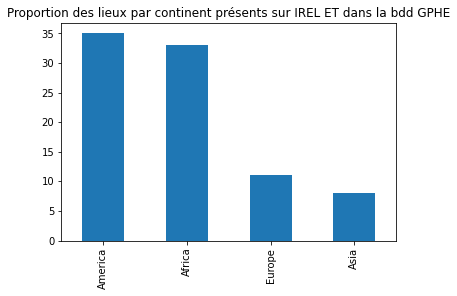

In [17]:
#Un plot pour avoir une idée des entités par continent que l'on trouve dans les deux 

df_WikiIREL["continent"].value_counts().plot.bar(title='Proportion des lieux par continent présents sur IREL ET dans la bdd GPHE')

In [18]:
from qwikidata.entity import WikidataItem, WikidataLexeme, WikidataProperty
from qwikidata.linked_data_interface import get_entity_dict_from_api

In [19]:
pattern = r"(Q\d+)"
df_wikiData["Q_code"] = df_wikiData["wikidata"].str.extract(pattern)

In [20]:
#Méthode en question (cf la fonction Extract_longlat_WikiData dans le module) : 

# pattern = r"(Q\d+)"
# df_wikiData["Q_code"] = df_wikiData["wikidata"].str.extract(pattern)
# List_Q_code =df_wikiData["Q_code"].tolist()
# #Tâche EXTREMEMENT longue.A n'executer qu'une fois : 
# df_longlatGPH = Extract_longlat_WikiData_all(List_Q_code)
# df_longlatGPH.to_csv("./GPH_coordonnees.csv")
# df_longlatGPH

On a donc décidé de récupérer uniquement les coordonnées des lieux paraissant dans les revues de 1898 à 1908.

In [21]:
GPELOC_GPH =pd.merge(df_wikiData,df_GPELOC,how="inner",on="NAME")[["NAME","Q_code"]]
# GPELOC_GPH

List_Q_code =GPELOC_GPH["Q_code"].tolist()

# df_longlatGPELOC_GPH = Extract_longlat_WikiData(List_Q_code)

In [22]:
list_lat=[]
list_long=[]

for Q_code in List_Q_code:
#     print(Q_code)
    if type(Q_code) == float:
        list_lat.append(None)
        list_long.append(None)
    else:
        q_dict = get_entity_dict_from_api(Q_code)


        if "P625"in q_dict["claims"] : #Si l'entité a des coordonnées

            #Latitude
            q_latitude = q_dict["claims"]["P625"][0]["mainsnak"]['datavalue']['value']['latitude']
            list_lat.append(q_latitude)

            #Longitude:
            q_longitude= q_dict["claims"]["P625"][0]["mainsnak"]['datavalue']['value']['longitude']
            list_long.append(q_longitude)

        else:
            list_lat.append(None)
            list_long.append(None) 

#Vérifier la taille des listes pour se prémunir d'un 
print("Avant correction. \nliste latitude : ",len(list_lat),"\nliste longitude : ",len(list_long),"\nList_Q_code : ",len(List_Q_code))

#s'Ily a une différence de taille entre list_long/list_lat et List_Q_code     
# list_long=list_long.append("0")
# list_lat=list_lat.append("0")

#     print("Après correction. \nliste latitude : ",len(list_lat),"\nliste longitude : ",len(list_long),"\nList_Q_code : ",len(List_Q_code))

# #création d'un df qui rassemble toutes les infos voulues et que l'on pourra merge par Q_code :
df_longlatGPELOC_GPH=pd.DataFrame({"Q_code":List_Q_code,"latitude":list_lat,"longitude":list_long})
  



Avant correction. 
liste latitude :  23 
liste longitude :  23 
List_Q_code :  23


In [23]:
df_longlatGPELOC_GPH.to_csv("./GPELOC_GPH_coordonnees.csv")
GPELOC_GPH=pd.merge(GPELOC_GPH,df_longlatGPELOC_GPH,how="left",on="Q_code")

# GPELOC_GPH

On merge cette liste avec celle de référence créée précédemment, `df_GPELOC`

In [24]:
df_GPELOC=pd.merge(df_GPELOC,GPELOC_GPH,how="outer",on="NAME")
# df_GPELOC

### 2.2.2. GPH x IREL : avoir une idée de ce que l'on pouvait trouver dans les deux 
#### (et qu'il faut donc extraire de la liste de recherche)

In [25]:
# On confirme que GPELOC_IRELGPH n'apporte rien  de nouveau 
pd.merge(GPELOC_IRELGPH,GPELOC_GPH,how="outer",on="NAME")

,NAME,Q_code,latitude,longitude
0,Cuba,Q241,22.000000,-79.500000
1,Guadeloupe,Q17012,16.250000,-61.583333
2,Martinique,Q17054,14.666667,-61.000000
3,France,Q142,47.000000,2.000000
4,Gibraltar,Q1410,36.137750,-5.345361
5,Niger,Q1032,17.000000,10.000000
6,Gabon,Q1000,-0.683331,11.500000
7,Philippines,Q928,12.000000,123.000000
8,Tagant,Q843903,18.700000,-10.200000
9,Yunnan,Q43194,24.500000,101.500000


## 2.3 IREL

In [26]:
df_IREL

,Administration,NAME,Type,titre
0,None,None,None,var geographie = [Aachen (Allemagne)
1,République du Congo,Abala,Subdivision,AbalaSubdivision (République du Congo)
2,Bénin,Abananquem,None,Abananquem (Bénin)
3,Algérie,Abbaziz,None,Abbaziz (Algérie)
4,Somme ; France,Abbeville,None,Abbeville (Somme ; France)
...,...,...,...,...
14566,Allemagne,Zusenhofen,None,Zusenhofen (Allemagne)
14567,Nord ; France,Zuytpeene,None,Zuytpeene (Nord ; France)
14568,Algérie,Z\'Mala,None,Z\Mala (Algérie)
14569,Algérie,Z’Malet El Emir Abdelkader,None,Z’Malet El Emir Abdelkader (Algérie)


### 2.3.1.reconstituer les URL de IREL:

In [27]:
#encoder les titres
list_titre_encoded =[]
for titre in df_IREL["titre"]:
    titre_encoded=urlencode(titre)
    list_titre_encoded.append(titre_encoded)

df_IREL["titre_encoded"] = list_titre_encoded

#reconstituer l'URL
list_url=[]
for encoded in df_IREL["titre_encoded"]:
    IREL_url= "http://anom.archivesnationales.culture.gouv.fr/geo.php?ir=&lieu="+encoded
    list_url.append(IREL_url)
    
df_IREL["IREL_url"] = list_url

#Chercher les coordonnées de chaque entrée:
#Beautiful Soup
pattern_coord_lat = r"\"value\"\:\{\"latitude\"\:(-?[\d]{1,2}\.[\d]*)\,"
pattern_coord_long = r"longitude\"\:(-?[\d]{1,3}\.[\d]*)\,"





Par économie de mémoire et de temps, à l'issue de la récupération des URL nous les avons exporté dans un csv trouvable ici : "./output_finaux/ListeCoordonnees.csv"

In [28]:
### LISTE des coordonnées récupérée et exportée dans "./output_finaux/ListeCoordonnees.csv"

# liste_coords=[]
# for url in df_IREL["IREL_url"]: 
#     coords = desambiguisation.Extract_longlat_IREL(url)
#     liste_coords.append(coords)
# df_IREL["Coordonnees"]=liste_coords
# df_IREL["Coordonnees"].to_csv("./output_finaux/ListeCoordonnees.csv",sep='\t',index=False)


In [29]:
df_IREL["Coordonnees"]=pd.read_csv("./output_finaux/ListeCoordonnees.csv",sep='\t')

#En faisant mon code précédent, j'ai fait une erreur en prenant dans la même colonne
#longitude et latitude. 
df_IREL=pd.concat([df_IREL,df_IREL["Coordonnees"].str.split(" ",expand=True)],axis=1)
df_IREL.rename(columns={0:"latitude",1:"longitude"})


,Administration,NAME,Type,titre,titre_encoded,IREL_url,Coordonnees,latitude,longitude
0,None,None,None,var geographie = [Aachen (Allemagne),var%20geographie%20%3D%20%5BAachen%20%28Allema...,http://anom.archivesnationales.culture.gouv.fr...,NaN,NaN,NaN
1,République du Congo,Abala,Subdivision,AbalaSubdivision (République du Congo),AbalaSubdivision%20%28R%C3%A9publique%20du%20C...,http://anom.archivesnationales.culture.gouv.fr...,NaN,NaN,NaN
2,Bénin,Abananquem,None,Abananquem (Bénin),Abananquem%20%28B%C3%A9nin%29,http://anom.archivesnationales.culture.gouv.fr...,6.2850 1.8118,6.2850,1.8118
3,Algérie,Abbaziz,None,Abbaziz (Algérie),Abbaziz%20%28Alg%C3%A9rie%29,http://anom.archivesnationales.culture.gouv.fr...,34.6167 2.8000,34.6167,2.8000
4,Somme ; France,Abbeville,None,Abbeville (Somme ; France),Abbeville%20%28Somme%20%3B%20France%29,http://anom.archivesnationales.culture.gouv.fr...,50.1 1.8333,50.1,1.8333
...,...,...,...,...,...,...,...,...,...
14566,Allemagne,Zusenhofen,None,Zusenhofen (Allemagne),Zusenhofen%20%28Allemagne%29,http://anom.archivesnationales.culture.gouv.fr...,48.5500 8.0167,48.5500,8.0167
14567,Nord ; France,Zuytpeene,None,Zuytpeene (Nord ; France),Zuytpeene%20%28Nord%20%3B%20France%29,http://anom.archivesnationales.culture.gouv.fr...,50.7947 2.4275,50.7947,2.4275
14568,Algérie,Z\'Mala,None,Z\Mala (Algérie),Z%5CMala%20%28Alg%C3%A9rie%29,http://anom.archivesnationales.culture.gouv.fr...,NaN,NaN,NaN
14569,Algérie,Z’Malet El Emir Abdelkader,None,Z’Malet El Emir Abdelkader (Algérie),Z%E2%80%99Malet%20El%20Emir%20Abdelkader%20%28...,http://anom.archivesnationales.culture.gouv.fr...,34.9000 2.3500,34.9000,2.3500


In [30]:
print("nombre de coordonnées manquantes : ",df_IREL["Coordonnees"].isna().sum())

df_IREL.loc[df_IREL["Coordonnees"].isna()]["titre"].sample(n=30)

#5805 noms de lieux sans coordonnées géographiques. 
#Il faudrait pour cela revoir les url constitués pour voir s'ils fonctionnent bien
##Le problème tient notamment à des problèmes de ponctuation, d'espace et d'appostrophe
##Question à régler plus tard pour avoir à l'avenir une bdd pertinente et réutilisable par toutes et tous 

nombre de coordonnées manquantes :  5805


8390                              MargaritaÎle (Venezuela)
5824                            HabraCours d\eau (Algérie)
10250                               Ouled Sekhar (Algérie)
482      Alima-LéfiniCirconscription (République du Congo)
5385                           GentillySeigneurie (Canada)
10242                               Ouled Naceur (Algérie)
7378                     La LussaudièreSeigneurie (Canada)
3148         ChandeleurÎles de la (Louisiane ; États-Unis)
3402     ChiloangaCours d\eau (République démocratique ...
13396                       ThekapointCours d\eau (Canada)
4019                               Dar El Fouini (Algérie)
5198              FranconieRégion géographique (Allemagne)
5640            Grand BélédougouRégion géographique (Mali)
13258                               TchiboboPointe (Gabon)
6370                               IviceÎle (BaléaresÎles)
12924                     SoussRégion géographique (Maroc)
1287     Bangui/Fort-CrampelVoie ferrée (République cen.

In [31]:
# df_IREL["Coordonnees"]

## Nettoyage des colonnes Aministration et Lieu-dit du df IREL 

Les deux colonnes en questions nous permettront de déterminer si oui ou non le lieu est géolocalisé dans la base de donnée IREL

In [32]:
df_IREL=IREL_Nettoyage_AdminLieuDit(df_IREL)


nouvelle colonne créée :  Administration_bis . au rang :  9

nouvelle colonne créée :  Lieu-dit_bis . au rang :  10


In [33]:
df_IREL

,Administration,NAME,Type,titre,titre_encoded,IREL_url,Coordonnees,0,1,Administration_bis,Lieu-dit_bis
0,None,None,None,var geographie = [Aachen (Allemagne),var%20geographie%20%3D%20%5BAachen%20%28Allema...,http://anom.archivesnationales.culture.gouv.fr...,NaN,NaN,NaN,,
1,République du Congo,Abala,Subdivision,AbalaSubdivision (République du Congo),AbalaSubdivision%20%28R%C3%A9publique%20du%20C...,http://anom.archivesnationales.culture.gouv.fr...,NaN,NaN,NaN,,
2,Bénin,Abananquem,None,Abananquem (Bénin),Abananquem%20%28B%C3%A9nin%29,http://anom.archivesnationales.culture.gouv.fr...,6.2850 1.8118,6.2850,1.8118,,
3,Algérie,Abbaziz,None,Abbaziz (Algérie),Abbaziz%20%28Alg%C3%A9rie%29,http://anom.archivesnationales.culture.gouv.fr...,34.6167 2.8000,34.6167,2.8000,,
4,Somme,Abbeville,None,Abbeville (Somme ; France),Abbeville%20%28Somme%20%3B%20France%29,http://anom.archivesnationales.culture.gouv.fr...,50.1 1.8333,50.1,1.8333,France,
...,...,...,...,...,...,...,...,...,...,...,...
14566,Allemagne,Zusenhofen,None,Zusenhofen (Allemagne),Zusenhofen%20%28Allemagne%29,http://anom.archivesnationales.culture.gouv.fr...,48.5500 8.0167,48.5500,8.0167,,
14567,Nord,Zuytpeene,None,Zuytpeene (Nord ; France),Zuytpeene%20%28Nord%20%3B%20France%29,http://anom.archivesnationales.culture.gouv.fr...,50.7947 2.4275,50.7947,2.4275,France,
14568,Algérie,Z\'Mala,None,Z\Mala (Algérie),Z%5CMala%20%28Alg%C3%A9rie%29,http://anom.archivesnationales.culture.gouv.fr...,NaN,NaN,NaN,,
14569,Algérie,Z’Malet El Emir Abdelkader,None,Z’Malet El Emir Abdelkader (Algérie),Z%E2%80%99Malet%20El%20Emir%20Abdelkader%20%28...,http://anom.archivesnationales.culture.gouv.fr...,34.9000 2.3500,34.9000,2.3500,,


In [34]:
#On récupère tous les noms de lieu: 
liste_colnames= ['Administration', 'NAME','Administration_bis',
       'Lieu-dit_bis']

liste_entites_clean=[]
for colname in liste_colnames:
    liste_entites_clean+=df_IREL[colname].to_list()
    
while None in liste_entites_clean:
        liste_entites_clean.remove(None)

liste_entites_clean

#Avoir une liste avec 1seule occurence de nom de lieu :
IREL_listeclean = pd.DataFrame(liste_entites_clean).rename(columns={0:"entites"})
IREL_listeclean = IREL_listeclean.groupby(by="entites").sum().index.values.tolist()

In [35]:
# IREL_listeclean

In [36]:
IREL_listeclean2=[]
for placeName in IREL_listeclean:
    
    if re.search(r" $",placeName):
        placeName=placeName.replace(re.search(r" $",placeName).group(0),"")    

    if re.search(r"^ ",placeName):
        placeName=placeName.replace(re.search(r"^ ",placeName).group(0),"")
    
    IREL_listeclean2.append(placeName)
# IREL_listeclean2

# Chercher quels noms de lieux de la liste de mon df se trouve dans celle des IREL  

Comme on a déjà trouvé certains lieux avec GPH, on retire ceslieux de `list_GPELOC`

In [49]:
df_GPELOC["latitude"]

,NAME,Q_code,latitude,longitude
0,Acores,NaN,NaN,NaN
1,Algérie,NaN,NaN,NaN
2,Allemagne,NaN,NaN,NaN
3,Angleterre,NaN,NaN,NaN
4,Annam,Q10828323,NaN,NaN
...,...,...,...,...
220,lac Tchad.,NaN,NaN,NaN
221,île de Saint-Barthélémy,NaN,NaN,NaN
222,île de Saint-Martin,NaN,NaN,NaN
223,île de la Réunion,NaN,NaN,NaN


In [37]:
L_MatchDF_IREL, L_NotMatchDF_IREL =MatchGPELOC_IREL(list_GPELOC,IREL_listeclean2)

nombre d'occurences identifiablespar IREL :  112 
nombre d'occurences non identifiables par IREL :  113
2 outputs : 
 1/L_MatchDF_IREL
 2/L_NotMatchDF_IREL


#### EXPLORATION DES DEUX LISTES POUR COMPRENDRE CE QUI N'EST PAS PASSE 

In [38]:
from desambiguisation import EgaliserTaille_MatchNot_IREL,nettoyage_desambiguisation,MatchGPELOC_IREL

In [39]:
# #pour que les deux listes aient la même longueur:
# lengthDiff=len(L_NotMatchDF_IREL)-len(L_MatchDF_IREL)
# L_MatchDF_IREL += list(np.empty(shape = (lengthDiff)))

L_MatchDF_IREL,L_NotMatchDF_IREL=EgaliserTaille_MatchNot_IREL(L_MatchDF_IREL,L_NotMatchDF_IREL)

comparaison_matchIREL = pd.DataFrame({'L_MatchDF_IREL' : L_MatchDF_IREL,
                                'L_NotMatchDF_IREL' : L_NotMatchDF_IREL},
                                columns=['L_MatchDF_IREL','L_NotMatchDF_IREL'])
#Pour exploration manuelle
comparaison_matchIREL.to_csv("./check_comparaisonMatchIREL.csv")

nouvelle taille L_Match_IREL2 113


In [40]:
#dictionnaire pour la désambiguisation :
Dico_desambiguisation = {"Guinée Française":["Guinée française"],
                         "Côte d'Ivoire":["côte d'Ivoire"],
                         "Pak-Hoi":["Pak-Hoï","Pakhoï"],
                         "Chengdu":['Tchen-Tou','Tchentou'],
                         "Yunnan":['Yun-Nam','Yun-Nan','Yunnam'],
                         "Hanoi":["Hanoï"],
                         "Laokay":["Lao-kay"],
                         "Côte d\'Ivoire":["Côte d'Ivoire","côte d'Ivoire"]
                        }
Liste_FP = ["Annamite","Annamites","île","Croyance","Port"]

#Problemes:
#Guinée trop flou pour être assigné à "Guinée française" car à la même époque existait
# une Guinée allemande et une britannique...

In [41]:
#Nettoyage en fonction de la désambiguisation 
liste_GPELOC = nettoyage_desambiguisation(Dico_desambiguisation,list_GPELOC)


In [42]:
L_MatchDF_IREL2, L_NotMatchDF_IREL2 = MatchGPELOC_IREL(list_GPELOC,IREL_listeclean2)

nombre d'occurences identifiablespar IREL :  112 
nombre d'occurences non identifiables par IREL :  113
2 outputs : 
 1/L_MatchDF_IREL
 2/L_NotMatchDF_IREL


In [44]:
#pour que les deux listes aient la même longueur:
lengthDiff=abs(len(L_NotMatchDF_IREL2)-len(L_MatchDF_IREL2))

if len(L_NotMatchDF_IREL2) > len(L_MatchDF_IREL2):
    L_MatchDF_IREL2 += list(np.empty(shape = (lengthDiff)))
    print("nouvelle taille L_Match_IREL2",len(L_Match_IREL2))
    
elif len(L_NotMatchDF_IREL2) < len(L_MatchDF_IREL2):
    L_NotMatchDF_IREL2 += list(np.empty(shape = (lengthDiff)))
    print("nouvelle taille L_NotMatch_IREL2",len(L_NotMatchDF_IREL2))

else:
    pass


In [45]:
print("Différence de taillent entre les deux listes : ",lengthDiff)
print("taille de L_NotMatchDF_IREL2 : ",len(L_NotMatchDF_IREL2))
print("taille de L_MatchDF_IREL2 : ",len(L_MatchDF_IREL2))

comparaison_matchIREL = pd.DataFrame({'L_MatchDF_IREL' : L_MatchDF_IREL2,
                                'L_NotMatchDF_IREL' : L_NotMatchDF_IREL2},
                                columns=['L_MatchDF_IREL','L_NotMatchDF_IREL'])
#Pour exploration manuelle
comparaison_matchIREL.to_csv("./check_comparaisonMatchIREL.csv")

Différence de taillent entre les deux listes :  0
taille de L_NotMatchDF_IREL2 :  113
taille de L_MatchDF_IREL2 :  113


<h3>Pour les entités trouvées : les associer aux df AHMC et AMN</h3>

In [46]:
comparaison_matchIREL.to_csv("./desambiguisation/comparaison_match_IREL.csv")

In [47]:
comparaison_matchIREL

,L_MatchDF_IREL,L_NotMatchDF_IREL
0,Algérie,Acores
1,Allemagne,Angleterre
2,Bizerte,Annam
3,Bordeaux,Asie
4,Brest,Buenos-Ayres
...,...,...
108,Vinh,lac Tchad.
109,Wallis,île de Saint-Barthélémy
110,Yunnan,île de Saint-Martin
111,Zinder,île de la Réunion


#### Maintenant on cherche à extraire de ` df_IREL ` les coordonnées des lieux qui ont matché 

In [ ]:
df_ensemble = pd.DataFrame()
for placeName in L_MatchDF_IREL2:
    df_placeName=df_IREL.loc[df_IREL["titre"].str.contains(placeName)]
    df_placeName["placeName"]=placeName
    df_ensemble=pd.concat([df_ensemble,df_placeName])
   

In [ ]:
# df_ensemble["placeName"]=df_ensemble["placeName"].drop_duplicates(keep="first")
df_ensemble_byPlaceName = df_ensemble.groupby(by="placeName").sum()

In [ ]:
# df_ensemble_byPlaceName=df_ensemble_byPlaceName.drop(columns=["titre_encoded","Administration_bis","Lieu-dit_bis"])
df_ensemble_byPlaceName.to_csv("./desambiguisation/IREL_parlieuxreconnus.csv")

#Nécessité de nettoyer IREL_url des localisations multiples. Nous n'en avons pas besoin car il nous suffit d'avoir un point en sont sein 
# df_ensemble_byPlaceName["IREL_url"].str.

In [ ]:
df_ensemble_byPlaceName

In [ ]:
df_byPlaceName_freq = df_ensemble.groupby(by="placeName").count().IREL_url
df_byPlaceName_freq.sort_values(ascending=False).head(30)

In [ ]:
df_byPlaceName_freq.loc[df_byPlaceName_freq<3000].plot()

# Geonames 
source: https://www.geonames.org/export/web-services.html

username= lgrumbach

In [ ]:
URL="Chine"

Geonames_url_base ="http://api.geonames.org/postalCodeLookupJSON?placename="+URL+"&username=lgrumbach"
Geonames_url_base

In [ ]:
URL = urlencode("Abala, Subdivision (République du Congo)")
url_base

# Etape 3 : trouver les coordonnées Wikidata GPH
## LISTE DES PROPERTIES :  https://www.wikidata.org/wiki/Wikidata:Database_reports/List_of_properties/all 

## European Colonialism :https://www.wikidata.org/wiki/Wikidata:WikiProject_European_Colonialism

## list of colonial empires:https://www.wikidata.org/wiki/Wikidata:WikiProject_European_Colonialism/list_of_colonial_empires

REssource pour seformer à SPARQL sur Wikidata : 
https://www.wikidata.org/wiki/Wikidata:SPARQL_tutorial#SPARQL_basics


Ce dont j'ai besoin:
SELCT ?coord
WHERE
{
#?coord has coord QID
    ?coord wd:QID
}


Items= wd: /// properties = wdt:.  
=> wdt AVANT wd

* ";" = AND
* "." = fin d'une requête
* "," = pour ajouter un item aux mêmes propriétés
* "[]" = Recherche relative.  Inside the brackets, you can specify predicate-object pairs, just like after a ;
* "p" : points not to the object, but to a statement node.
    *  This node then is the subject of other triples: 
        * ps: (for property statement) points to the statement object,
        * pq: (property qualifier) to qualifiers, 
        * prov:wasDerivedFrom points to reference nodes (which we’ll ignore for now).


AJouter : 
SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
=> Sert à afficher le label associé à l'entité recherchée

**Instances and classes**

"has" // "is" 
[objet particulier] IS [concept/subclass] 
=> différencier concept et subclass -> essayer de remplacer "is" par "is a kind of". SI ça marche, c'est une subclass. Sinon un concept. 
ex: Gone with the wind "is a kind of" film =>  marche pas => film est un concept


**Property paths**


wdt:P31/wdt:P279/wdt:P279 
P31 = nature de l'el
P279 =sous-classede [eltavant]

wdt:
* **P31** = nature del'élt
* **P625** = coordonnées géo
* **P17**	= country
* **P530**	diplomatic relation
* rdfs:label "Mary Wollstonecraft"@en;
* **P945** =	allegiance	country (or other power) that the person or organization serves
* **P1376**	capital of	country, state, department, canton or other administrative division of which the municipality is the governmental seat
* **P8119**	HASC	codes to represent country subdivisions
* **Q133156** colony 
* **Q161243** dependent territory

=> pour éviter de listertoutes lessubclass, on peut écrire "*" ou "+" comme enregex

**Qualifiers**




**Globe oordinates**

Coordinate text values have value type globecoordinate and property type globe-coordinate.

The simple value of the coordinate is the WKT string with the coordinates, with type geo:wktLiteral, e.g.: "Point(35.3 12.93)"^^geo:wktLiteral. The order of the coordinates in WKT is longitude, latitude (since format version 0.0.2).

The full value has latitude, longitude and precision as double, and the globe as IRI.


**Wikibase Entity Id** 

Wikibase Entity Id values have value type wikibase-entityid and property type wikibase-item.


In [ ]:
## Faire lien avec les données wikidata de GPH

### Extraire les entity ID de chaque lien wikidata

In [ ]:
def wikidata_extractID(df,ncol):

    ListEntityID = []
    for i in range (len(df)):
        wikiurl = df.iloc[i,ncol]
    #     print(type(wikiurl))
        if type(wikiurl) is float:
            ListEntityID.append(wikiurl)
        else:
            entityID = re.search(r'[A-Z][0-9]+$',wikiurl).group(0)
            ListEntityID.append(entityID)
    return ListEntityID

In [ ]:
#wikidata
wikiURL1 = wikidata_extractID(df_WikiQGIS,3)
df_WikiQGIS["entityID_1"]=wikiURL1

#wikidata_alt1
wikiURLalt1 = wikidata_extractID(df_WikiQGIS,4)
df_WikiQGIS["entityID_alt1"]=wikiURLalt1

#wikidata_alt2
wikiURLalt2 = wikidata_extractID(df_WikiQGIS,5)
df_WikiQGIS["entityID_alt2"]=wikiURLalt2

#NB: il n'y a pas de wikidata_alt3 pour la période concernée
df_WikiQGIS.iloc[2,14]
df_WikiQGIS

In [ ]:
df_WikiQGIS

### Recherche des coordonnées via l'API wikidata